<center> <h2> Music Genre Classification </h2> </center>
<center><h4>Amir Bagheri</h4></center>

<a id="3"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

### Importing Packages & Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import librosa
import librosa.display as lplt
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, make_scorer, RocCurveDisplay 
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.feature_selection import RFE

In [3]:
seed = 42
np.random.seed(seed)

<a id="3"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## Data Exploration

### Importing Data

In [4]:
import os
general_path = '../Final/Data'

In [5]:
df = pd.read_csv(f'{general_path}/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [6]:
print("Dataset shape:", df.shape)
print("Quantity of songs in each genre:")
df.label.value_counts().reset_index()

Dataset shape: (9990, 60)
Quantity of songs in each genre:


,index,label
0,blues,1000
1,jazz,1000
2,metal,1000
3,pop,1000
4,reggae,1000
5,disco,999
6,classical,998
7,hiphop,998
8,rock,998
9,country,997


### Visualizing Audio

In [7]:
# Import Stayin' Alive by Bee Gees
stayin_alive_fp = f'{general_path}/genres_original/disco/disco.00014.wav'
audio_data, sr = librosa.load(stayin_alive_fp)
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
# Result is a numpy ndarray
audio_data, _ = librosa.effects.trim(audio_data)

print('y:', audio_data, '\n')
print('y shape:', np.shape(audio_data), '\n')
print('Sample Rate (KHz):', sr, '\n')
# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [ 0.20974731  0.13619995  0.14807129 ... -0.16918945 -0.19021606
 -0.21813965] 

y shape: (661344,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [8]:
# Default Fast Fourier Transform (FFT) window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for Short-time Fourier transform (STFT)

# STFT
stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
# Convert an amplitude spectrogram to a decibels-scaled spectrogram
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

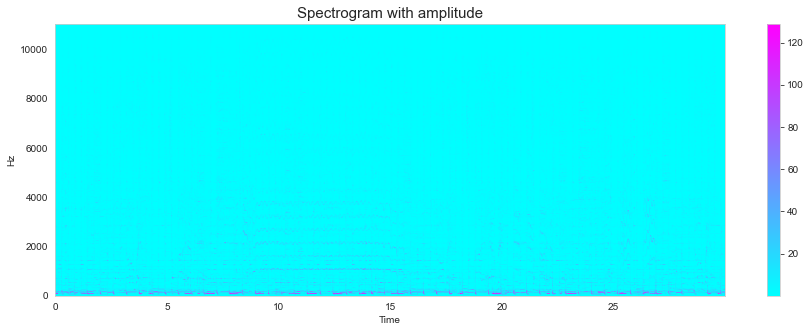

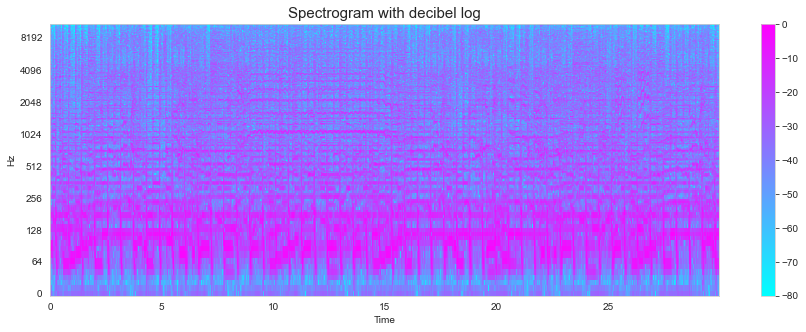

In [9]:
# Creating the Spectograms
plt.figure(figsize=(15,5))
lplt.specshow(stft, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with amplitude", fontsize=15)
plt.show()

plt.figure(figsize=(15,5))
lplt.specshow(stft_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar();
plt.title("Spectrogram with decibel log", fontsize=15)
plt.show()

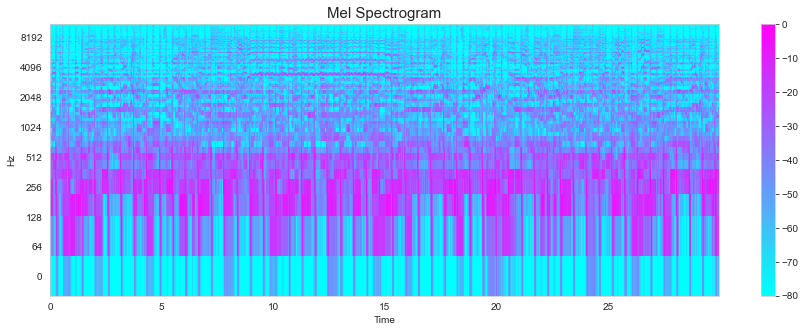

In [10]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(15,5))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool');
plt.colorbar();
plt.title("Mel Spectrogram", fontsize=15);
plt.show()

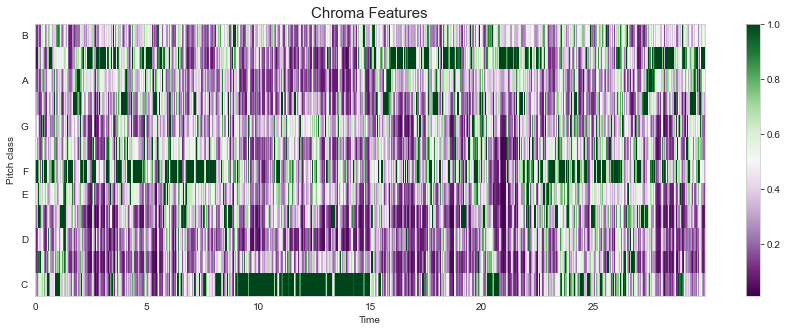

In [11]:
chromagram = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(15,5))
lplt.specshow(chromagram, sr=sr, x_axis='time', y_axis='chroma', cmap='PRGn')
plt.colorbar()
plt.title("Chroma Features", fontsize=15)
plt.show()

### Audio Features

In [12]:
# Tempo of Stayin' Alive in BPM
tempo, _ = librosa.beat.beat_track(audio_data, sr=sr)
tempo

103.359375

In [13]:
# Total zero_crossings in Stayin' Alive
zero_crossings = librosa.zero_crossings(audio_data, pad=False)
print(sum(zero_crossings))

103501


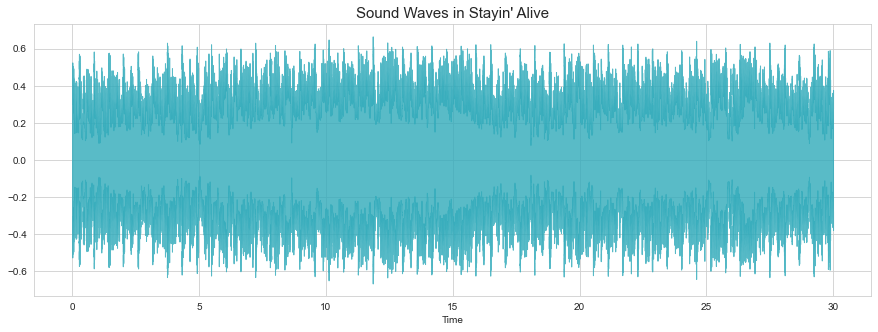

In [14]:
plt.figure(figsize=(15,5))
librosa.display.waveshow(y=audio_data, sr=sr, alpha=.8, color="#30AABA");
plt.title("Sound Waves in Stayin' Alive", fontsize=15);
plt.show()

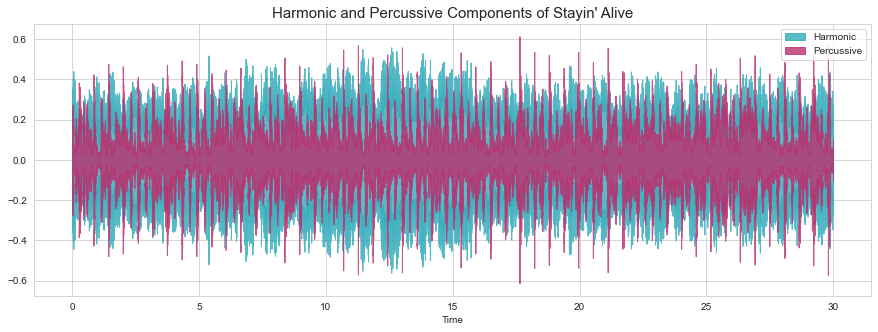

In [15]:
# Decompose audio into harmonic and percussive components
y_harm, y_perc = librosa.effects.hpss(audio_data)

plt.figure(figsize = (15,5))
lplt.waveshow(y_harm, sr=sr, alpha=.8, color='#30AABA', label='Harmonic')
lplt.waveshow(y_perc, sr=sr, alpha=.8, color='#BA306E', label='Percussive')
plt.legend()
plt.title("Harmonic and Percussive Components of Stayin' Alive", fontsize=15)
plt.show()

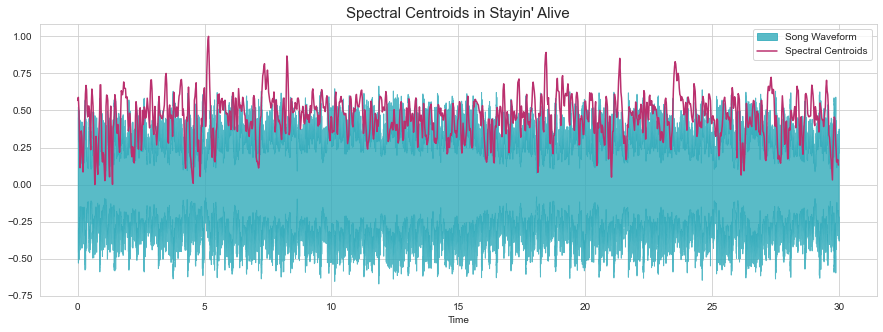

In [16]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(audio_data, sr=sr)[0]
# Compute time variable for visualization
frames = range(len(spectral_centroids))
# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

plt.figure(figsize=(15,5))
lplt.waveshow(audio_data, sr=sr, alpha=0.8, color='#30AABA', label='Song Waveform');
plt.plot(t, normalize(spectral_centroids), color='#BA306E', label='Spectral Centroids');
plt.legend()
plt.title("Spectral Centroids in Stayin' Alive", fontsize=15)
plt.show()

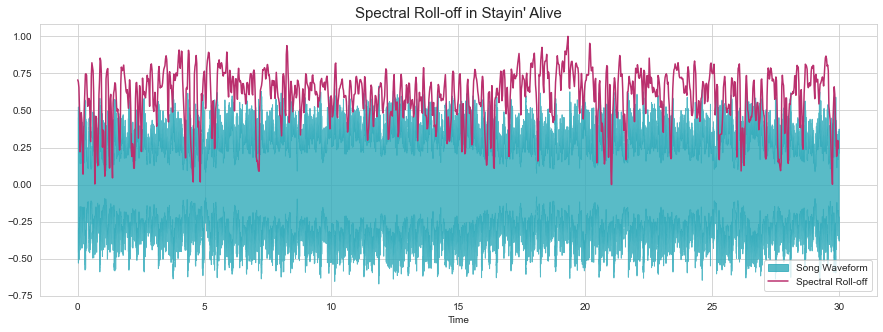

In [17]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_data, sr=sr)[0]

plt.figure(figsize=(15,5))
lplt.waveshow(audio_data, sr=sr, alpha=0.8, color='#30AABA', label='Song Waveform');
plt.plot(t, normalize(spectral_rolloff), color='#BA306E', label='Spectral Roll-off');
plt.legend()
plt.title("Spectral Roll-off in Stayin' Alive", fontsize=15)
plt.show()

### Exploratory Data Analysis

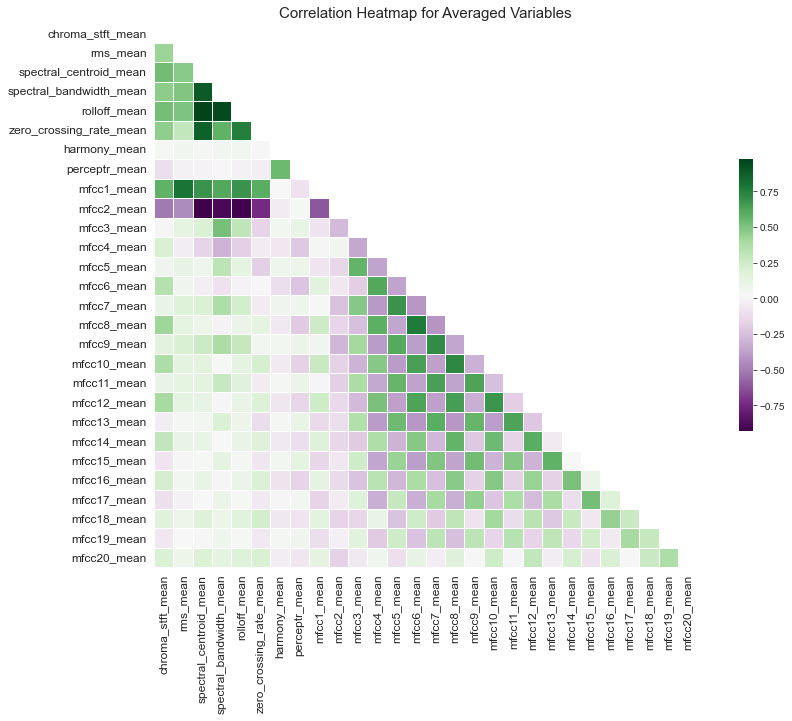

In [19]:
# Compute the Correlation Matrix
mean_cols = [col for col in df.columns if 'mean' in col]
corr = df[mean_cols].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask, cmap='PRGn', square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.title('Correlation Heatmap for Averaged Variables', fontsize=15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()
# plt.savefig("CorrHeatmap.png")

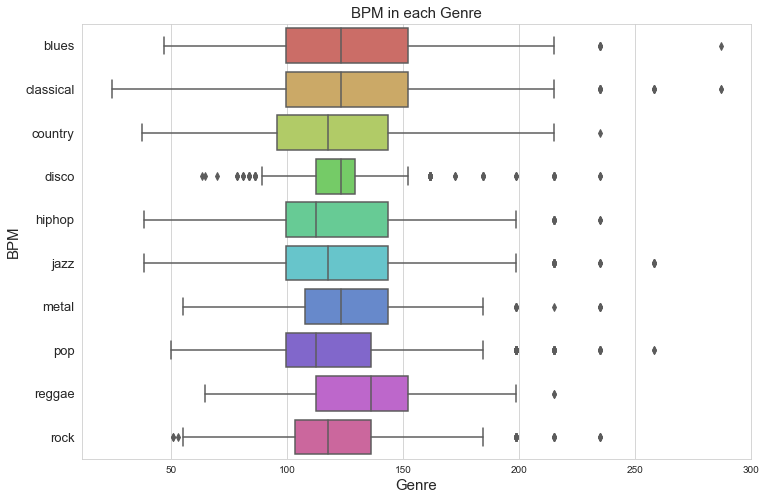

In [20]:
x = df[['label', 'tempo']]
plt.figure(figsize=(12,8))
sns.boxplot(x='tempo', y='label', data=x, palette='hls', orient='h');
plt.title('BPM in each Genre', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=13);
plt.xlabel('Genre', fontsize=15)
plt.ylabel('BPM', fontsize=15)
plt.show()
# plt.savefig("BPMBoxplot.png")

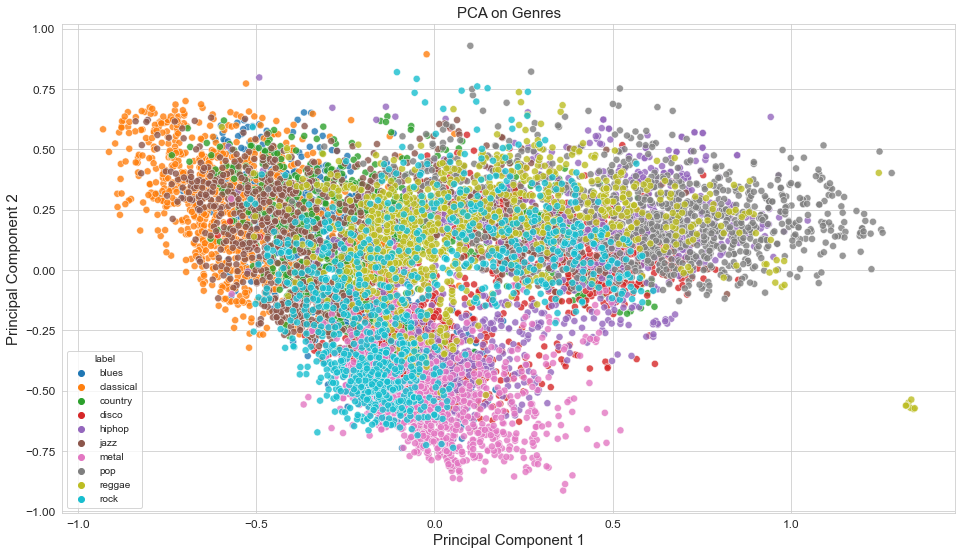

In [21]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# Normalize X
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns=cols)

# Top 2 PCA Components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis=1)

plt.figure(figsize =(16,9))
sns.scatterplot(x='PC1', y='PC2', data=finalDf, hue='label', alpha=0.8, s=50);
plt.title('PCA on Genres', fontsize=15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.show()
# plt.savefig("PCA_Scatter.png")

<a id="3"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## Data Pre-Processing

In [22]:
# find all columns with any NA values
print("Columns with NA values:",list(df.columns[df.isnull().any()]))

Columns with NA values: []


In [23]:
# Encode Genre Label
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

# Update labels in df to index
df.label = [label_index[l] for l in df.label]

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [24]:
# Shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)
df_shuffle.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,hiphop.00002.8.wav,66149,0.404232,0.096884,0.090223,0.000638,1416.001997,465268.853752,1973.083395,185535.919214,...,55.957241,-4.883339,53.092667,1.034924,20.556194,-4.238788,31.233484,-2.934530,34.166332,4
1,jazz.00042.0.wav,66149,0.243589,0.084304,0.090146,0.000930,1206.214018,48883.472876,1523.543854,24788.400357,...,25.465181,-4.751444,25.725513,-8.050362,18.618586,-9.862431,53.661839,-11.109019,12.743995,5
2,blues.00048.7.wav,66149,0.355097,0.086465,0.130576,0.001197,2293.981066,184298.037527,2181.331825,108973.121405,...,65.851204,-4.983762,28.220079,-4.208559,46.466846,-8.962951,47.620399,-3.131865,34.480564,0
3,blues.00003.9.wav,66149,0.387297,0.092417,0.149871,0.005382,1061.389626,128482.413202,1665.487663,123692.389644,...,61.515476,-7.273301,54.165520,0.735078,30.324575,-2.341069,49.825420,-6.121044,18.358120,0
4,metal.00080.3.wav,66149,0.419387,0.079487,0.153464,0.001511,2739.278464,81717.413705,2410.267381,12507.457839,...,28.295105,-3.922399,25.422867,3.707712,34.378510,-9.237077,65.149940,1.359221,57.023216,6


In [25]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
y = df_shuffle.pop('label')
df_X = df_shuffle

# Normalize so everything is on the same scale. 
cols = df_X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns=cols)
X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.462542,0.772012,0.202143,0.019575,0.190181,0.096897,0.459311,0.149399,0.276373,0.216050,...,0.480365,0.080034,0.370627,0.097526,0.377247,0.027333,0.394629,0.024705,0.468215,0.037228
1,0.212463,0.652902,0.201970,0.028512,0.147884,0.010029,0.319223,0.019129,0.210476,0.044564,...,0.343715,0.035364,0.372759,0.045668,0.219801,0.024240,0.299011,0.044376,0.351191,0.013691
2,0.386052,0.673366,0.293521,0.036694,0.367201,0.038280,0.524206,0.087353,0.459383,0.076872,...,0.426217,0.094528,0.369003,0.050395,0.286379,0.068705,0.314305,0.039078,0.465390,0.037573
3,0.436178,0.729716,0.337213,0.165009,0.118684,0.026635,0.363456,0.099281,0.162102,0.083882,...,0.446344,0.088176,0.331991,0.099559,0.372051,0.042931,0.426896,0.041012,0.422598,0.019860
4,0.486134,0.607292,0.345348,0.046319,0.456982,0.016879,0.595548,0.009177,0.584442,0.015150,...,0.578005,0.039509,0.386161,0.045095,0.423566,0.049404,0.309644,0.054452,0.529684,0.062340


<a id="3"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## Classification Model Building & Evaluation

### Evaluating Baseline Model Performances

In [26]:
# Shuffles testing and training sets by default
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=seed, stratify=y)


estimators = {
    'k-Nearest Neighbor': KNeighborsClassifier(), 
    'Support Vector Machine': SVC(decision_function_shape="ovo"),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0),
    'Logistic Regression': LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'),
    'Cross Gradient Booster': XGBClassifier(n_estimators=500, learning_rate=0.05)}


In [27]:
n_splits = 5
kfold = KFold(n_splits=n_splits, random_state=seed, shuffle=True)

# Pre-defined function to assess models
def assess_model(model, title):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score, average = 'macro'),
               'recall' : make_scorer(recall_score, average = 'macro'), 
               'f1_score' : make_scorer(f1_score, average = 'macro')}
    
    model_scores = cross_validate(estimator=model, X=X, y=y, scoring=scoring, cv=kfold, return_train_score=True, return_estimator=True)
    print(title, ':', f'{n_splits}-fold Cross Validation:')
    print('\tMean Accuracy: ', round(model_scores['test_accuracy'].mean(), 4))
    print('\tMean Precision: ', round(model_scores['test_precision'].mean(), 4))
    print('\tMean Recall: ', round(model_scores['test_recall'].mean(), 4))
    print('\tMean F1_score: ', round(model_scores['test_f1_score'].mean(), 4))
    print('\tMean Training Set Accuracy: ', round(model_scores['train_accuracy'].mean(), 4), '\n')

In [28]:
# Pre-defined function to assess models (Without CV for faster processing)
def model_assess_no_cv(model, title):
    model.fit(X_train, y_train)
    preds = model.predict(X_test) 
    print(title, ':')
    print('Accuracy:', round(accuracy_score(y_test, preds), 4), '\n')

In [29]:
# Gaussian Naive Bayes
nb = GaussianNB()
assess_model(nb, 'Gaussian Naive Bayes')

Gaussian Naive Bayes : 5-fold Cross Validation:
	Mean Accuracy:  0.5198
	Mean Precision:  0.5295
	Mean Recall:  0.5204
	Mean F1_score:  0.5028
	Mean Training Set Accuracy:  0.5257 



In [30]:
# k-Nearest Neighbor
knn = KNeighborsClassifier()
assess_model(knn, 'k-Nearest Neighbor')

k-Nearest Neighbor : 5-fold Cross Validation:
	Mean Accuracy:  0.9024
	Mean Precision:  0.904
	Mean Recall:  0.9023
	Mean F1_score:  0.9022
	Mean Training Set Accuracy:  0.9471 



In [31]:
# Decision Tree
tree = DecisionTreeClassifier()
assess_model(tree, 'Decision Tree')

Decision Tree : 5-fold Cross Validation:
	Mean Accuracy:  0.6489
	Mean Precision:  0.6502
	Mean Recall:  0.6492
	Mean F1_score:  0.6489
	Mean Training Set Accuracy:  0.9992 



In [32]:
# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
assess_model(rforest, 'Random Forest')

Random Forest : 5-fold Cross Validation:
	Mean Accuracy:  0.8069
	Mean Precision:  0.8095
	Mean Recall:  0.8076
	Mean F1_score:  0.8054
	Mean Training Set Accuracy:  0.962 



In [33]:
# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
assess_model(svm, 'Support Vector Machine')

Support Vector Machine : 5-fold Cross Validation:
	Mean Accuracy:  0.7554
	Mean Precision:  0.7551
	Mean Recall:  0.7561
	Mean F1_score:  0.7536
	Mean Training Set Accuracy:  0.7785 



In [34]:
# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
assess_model(lg, 'Logistic Regression')

Logistic Regression : 5-fold Cross Validation:
	Mean Accuracy:  0.6878
	Mean Precision:  0.6848
	Mean Recall:  0.6888
	Mean F1_score:  0.6843
	Mean Training Set Accuracy:  0.7009 



In [35]:
# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05)
assess_model(xgb, 'Cross Gradient Booster')

Cross Gradient Booster : 5-fold Cross Validation:
	Mean Accuracy:  0.9069
	Mean Precision:  0.9077
	Mean Recall:  0.907
	Mean F1_score:  0.9068
	Mean Training Set Accuracy:  0.9992 



### Optimizing Best Performing Models

#### k-Nearest Neighbor:

In [36]:
# Hyperparameters to tune:
n_neighbors = [1, 2, 3, 4, 5, 10, 20, 30]
p = [1, 2]

# Tuning k-Nearest Neighbors
knn_2 = KNeighborsClassifier()
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
knn_2 = GridSearchCV(knn_2, hyperparameters, cv=kfold)
best_model = knn_2.fit(X, y)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 30
Best p: 1
Best n_neighbors: 1


In [39]:
# k-Nearest Neighbor with optimal tuning: p=1 (default) and n_neighbors=1
knn = KNeighborsClassifier(n_neighbors=1)
assess_model(knn, 'k-Nearest Neighbor')

k-Nearest Neighbor : 5-fold Cross Validation:
	Mean Accuracy:  0.9309
	Mean Precision:  0.9311
	Mean Recall:  0.9309
	Mean F1_score:  0.9307
	Mean Training Set Accuracy:  0.9992 



In [38]:
# Manual Tuning of Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.15)
assess_model(xgb, 'Cross Gradient Booster')

Cross Gradient Booster : 5-fold Cross Validation:
	Mean Accuracy:  0.9103
	Mean Precision:  0.9105
	Mean Recall:  0.9105
	Mean F1_score:  0.9101
	Mean Training Set Accuracy:  0.9992 

